#  Code for 2D staggered Lagrangian method in Cartersian coordinates

## Control equations

### Momentum equation

$$\tag{1.1}\rho \frac{d\mathbf{v}}{dt} =  -\nabla p $$ 
where $\mathbf{v}$ is the vector of velocity, and $\rho$ is the density and $p$ is the pressure.  

### Energy equation

$$ \rho \frac{dE}{dt} = -\nabla \cdot (p\mathbf{v})$$ 

where $E$ is the specific total energy and it has a realtion with the specific internal energy 
$$E = e + \frac{1}{2}\mathbf{v}\cdot\mathbf{v}$$

By (1.1) and (1.2) we have 
$$\tag{1.3} \rho \frac{de}{dt} = - p\nabla\cdot \mathbf{v}$$

In  a Cartersian coordinates $x-y$, The equations (1.1) and (1.3) can be written as
$$\rho \frac{du}{dt} = -\frac{\partial p}{\partial x},\quad \rho \frac{dv}{dt} = -\frac{\partial p}{\partial y}$$
and
$$\rho \frac{de}{dt} = -p (\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y})$$

## Compatible Staggered Discretization

<img src="Grid.png" width = "800" height = "400" div align=center /> 

<img src="cellpoint.png" width = "800" height = "400" div align=center />

### Quatities:

On point: ($x_p$,$y_p$), ($u_p$,$v_p$)

Zonal:  $V_z$, $\rho_z$, $m_z$, $e_z$, $p_z$

By the relation 
$$\frac{dm_z}{dt} =0$$
we have 
$$\rho_z(t) = m_z/V_z(t)$$

Also 
$$d(x_p)/dt = u_p, \quad d(y_p)/dt = v_p$$

### Point mass 

Point mass $m_p$ is used to solve point momentum $\mu_p = m_p \bf{u}_p$ and kinetic energy $K_p = m_p \frac{\bf{u}_p^2}{2}$

<img src="Ins.jpg" width = "200" height = "400" div align=center /> 

$$m_p = \sum_{z\in Z(p)} A_z^p \rho^p_z$$

$$\rho_z(t) = m_z/V_z(t)$$

In [173]:
function MassAndDens(mz::Array{Float64,1},x::Array{Float64,1},y::Array{Float64,1})
    
    Ic, = size(mz)
    Ip, = size(Tc)
    Asbz = zeros(Float64,4)
    ρ = zeros(Float64,Ic)
    mp = zeros(Float64,Ip)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    for i in 1:Ic
        xz[1:4] = x[Tp[i,1:4]]
        yz[1:4] = y[Tp[i,1:4]]
        Asbz = A_z(xz,yz)
        Az = sum(Asbz[j] for j in 1:4)
        ρ[i] = mz[i]/Az
        
        for j = 1:4
            ip = Tp[i,j]
            mp[ip] = mp[ip] + Asbz[j]*ρ[i]
        end
    end
    return ρ,mp
end           
        

MassAndDens (generic function with 1 method)


$$ A_z^1 = \frac{5A_{41}+5A_{12}+A_{23}+A_{34}}{12}$$
$$ A_z^2 = \frac{A_{41}+5A_{12}+5A_{23}+A_{34}}{12}$$
$$ A_z^3 = \frac{A_{41}+A_{12}+5A_{23}+5A_{34}}{12}$$
$$ A_z^4 = \frac{5A_{41}+A_{12}+A_{23}+5A_{34}}{12}$$

In [208]:
function A_z(xz::Array{Float64,1},yz::Array{Float64,1}) 
    A =zeros(Float64,4)
    xc= sum(xz[i] for i in 1:4)/4
    yc= sum(yz[i] for i in 1:4)/4
    
    A41 = Area3(xz[4],xz[1],xc,yz[4],yz[1],yc)
    A12 = Area3(xz[1],xz[2],xc,yz[1],yz[2],yc)
    A23 = Area3(xz[2],xz[3],xc,yz[2],yz[3],yc)
    A34 = Area3(xz[3],xz[4],xc,yz[3],yz[4],yc)

    A[1] = (5A41+5A12+A23+A34)/12
    A[2] = (A41+5A12+5A23+A34)/12
    A[3] = (A41+A12+5A23+5A34)/12
    A[4] = (5A41+A12+A23+5A34)/12
    
    

    return A
end

A_z (generic function with 2 methods)

<img src="Ins2.jpg" width = "400" height = "300" div align=center />

In [167]:
function F_z(x::Array{Float64,1},y::Array{Float64,1},p::Float64)
   
    Fx = zeros(Float64,4)
    Fy = zeros(Float64,4)
    
    L12 = √((x[2]-x[1])^2+(y[2]-y[1])^2)
    n12x = (-y[2]+y[1])/L12
    n12y = (x[2]-x[1])/L12
    
    L41 = √((x[1]-x[4])^2+(y[1]-y[4])^2)
    n41x = (-y[1]+y[4])/L41
    n41y = (x[1]-x[4])/L41
    
    L23 = √((x[3]-x[2])^2+(y[3]-y[2])^2)
    n23x = (-y[3]+y[2])/L23
    n23y = (x[3]-x[2])/L23
    
    L34 = √((x[4]-x[3])^2+(y[4]-y[3])^2)
    n34x = (-y[4]+y[3])/L34
    n34y = (x[4]-x[3])/L34
    
    Fx[1] = p*(L12*n12x+L41*n41x)/2
    Fy[1] = p*(L12*n12y+L41*n41y)/2
    
    Fx[2] = p*(L12*n12x+L23*n23x)/2
    Fy[2] = p*(L12*n12y+L23*n23y)/2
    
    Fx[3] = p*(L23*n23x+L34*n34x)/2
    Fy[3] = p*(L23*n23y+L34*n34y)/2
    
    Fx[4] = p*(L34*n34x+L41*n41x)/2
    Fy[4] = p*(L34*n34y+L41*n41y)/2
    
    return Fx,Fy
    end           

F_z (generic function with 1 method)

对于单元 
$$ m_z \frac{de_z}{dt} = -\sum_{z\in Z(p)} \bf{f}_z^p \cdot \bf{u}_p $$  

对于节点
$$m_p \frac{d\bf{u}_p}{dt} = \sum_{p\in P(z)} \bf{f}_z^p$$

In [50]:
function Rhs(x::Array{Float64,1},y::Array{Float64,1},u::Array{Float64,1},v::Array{Float64,1},p::Array{Float64,1})  #Right hand e
    Ic, = size(Tp)
    Ip, = size(Tc)
    rhsu = zeros(Float64,Ip)
    rhsv = zeros(Float64,Ip) 
    rhse = zeros(Float64,Ic)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    
    for i in 1:Ic
        for j =1:4
            xz[j] = x[Tp[i,j]]
            yz[j] = y[Tp[i,j]]
        end
        Fx,Fy = F_z(xz,yz,p[i])
        
        ∑=0
        for j in 1:4
            ip = Tp[i,j]
            ∑ = ∑ +u[ip]*Fx[j] + v[ip]*Fy[j]
        end
        rhse[i] = -∑
        
        for j = 1:4
            ip = Tp[i,j]
            rhsu[ip] +=  Fx[j]
            rhsv[ip] +=  Fy[j]
        end     
    end
    return rhse, rhsu,rhsv
end

Rhs (generic function with 1 method)

In [133]:
function Euler1st(dt,u,v,x,y,p,mz,ρ)
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,x,y)
    
    e = pToe(p, ρ,problem.γ)
    rhse, rhsu,rhsv = Rhs(x,y,u, v, p)
   rhsu,rhsv = Bound(rhsu,rhsv,x,y,u, v, p)
    
    u  += dt*(rhsu ./ mp)
    v  += dt*(rhsv ./ mp)
    e  += dt*(rhse ./ mz)
    
    x  +=  dt*u
    y  +=  dt*v
    
    ρ,mp = MassAndDens(mz,x,y)
    
    p = eTop(e, ρ,problem.γ)
    return u,v,x,y,p,ρ
end

Euler1st (generic function with 1 method)

In [135]:
function Bound(rhsu,rhsv,x,y,u,v,p)
    Ip, = size(Tc)
    Ib, = size(Tb)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    for i in 1:Ib
        ip = Tb[i,1]
    #    @show ip
        for j = 1:4
            ic = Tc[ip,j]
            if ic != 0
                xz[1:4] = x[Tp[ic,1:4]]
                yz[1:4] = y[Tp[ic,1:4]]
                if Tb[i,2] ==1 
                    Fx,Fy = F_zB(xz,yz,p[ic],j,1)
                    rhsu[ip] -= Fx
                    rhsv[ip] -= Fy
                   # mp[ip] *= 2.0
                end
                if Tb[i,3] ==1
                    Fx,Fy = F_zB(xz,yz,p[ic],j,2)
                    rhsu[ip] -= Fx
                    rhsv[ip] -= Fy
                   # mp[ip] *= 2.0
                end
            end
        end
    end
    return rhsu, rhsv
end  

Bound (generic function with 2 methods)

### Boundary force



In [48]:
function F_zB(x::Array{Float64,1},y::Array{Float64,1},p::Float64,j::Int,k::Int)
    Fx = 0.0
    Fy = 0.0      
    if k==1 # y direction 
        L12 = √((x[2]-x[1])^2+(y[2]-y[1])^2)
        n12x = (-y[2]+y[1])/L12
        n12y = (x[2]-x[1])/L12
        L34 = √((x[4]-x[3])^2+(y[4]-y[3])^2)
        n34x = (-y[4]+y[3])/L34
        n34y = (x[4]-x[3])/L34
        if j == 1  #Point 1
            Fx = p*(L12*n12x)/2
            Fy = p*(L12*n12y)/2
        elseif j == 2 
            Fx = p*(L12*n12x)/2
            Fy = p*(L12*n12y)/2
        elseif j == 3
            Fx = p*(L34*n34x)/2
            Fy = p*(L34*n34y)/2
        else 
            Fx = p*(L34*n34x)/2
            Fy = p*(L34*n34y)/2
        end
    elseif k == 2
        L41 = √((x[1]-x[4])^2+(y[1]-y[4])^2)
        n41x = (-y[1]+y[4])/L41
        n41y = (x[1]-x[4])/L41

        L23 = √((x[3]-x[2])^2+(y[3]-y[2])^2)
        n23x = (-y[3]+y[2])/L23
        n23y = (x[3]-x[2])/L23
        if j == 1
            Fx = p*(L41*n41x)/2
            Fy = p*(L41*n41y)/2
        elseif j == 2 
            Fx = p*(L23*n23x)/2
            Fy = p*(L23*n23y)/2
        elseif j == 3
            Fx = p*(L23*n23x)/2
            Fy = p*(L23*n23y)/2
        else 
            Fx = p*(L41*n41x)/2
            Fy = p*(L41*n41y)/2
        end
    end
    return Fx,Fy
    end           

F_zB (generic function with 1 method)

### EOS 
$$ e = \frac{p}{(\gamma-1)\rho}$$

In [14]:
function pToe(p,ρ,γ)
    return p ./ ρ/(γ-1)
end
function eTop(e,ρ,γ)
    return (γ-1)*ρ .* e
end

eTop (generic function with 1 method)

In [15]:
function CFL(SF,x::Array{Float64,1},y::Array{Float64,1},
                u::Array{Float64,1},v::Array{Float64},
                p::Array{Float64,1},ρ::Array{Float64,1})
    Ic, = size(ρ)
    cflmin = 1.e9
    cfl =0
    γ = problem.γ
    for i in 1:Ic
        u2max = 0
        u2=0.0
        for j = 1:4
            u2 = u[j]^2+v[j]^2
            if u2 > u2max ; u2max = u2; end
        end
        
        dlmin = 1.e9
        for j=1:3
            dl= (x[j+1] - x[j])^2+(y[j+1]-y[j])^2
            if dl < dlmin; dlmin=dl; end
        end
        c = √(γ*p[i]/ρ[i])
        cfl = √(dlmin)/(√(u2)+c)
        if cfl < cflmin; cflmin = cfl; end
    end
    dt = cfl*SF
    return dt
end 
        

CFL (generic function with 1 method)

In [212]:
function TimeSolve(u,v,x,y,p,mz,ρ)
    tt= problem.tt
    sf =problem.sf
    t= 0.0
#    while t<tt
for i in 1:3
        dt=CFL(sf,x,y,u,v,p,ρ)
        if t+dt>tt
           dt = tt-t
        end
        
        u,v,x,y,p,ρ = Euler1st(dt,u,v,x,y,p,mz,ρ)
    t += dt
        println(t)
    end
#
    return u,v,x,y,p,ρ
end

TimeSolve (generic function with 1 method)

In [213]:
x,y,u,v,mz,p,ρ,Az=InitTest1()
u,v,x,y,p,ρ = TimeSolve(u, v, x, y, p, mz,ρ)
Output(x, y, u, v, p, ρ, mz)

0.0012677313820927745
0.002535462764185549
0.003803194146278324


In [149]:
using Plots   

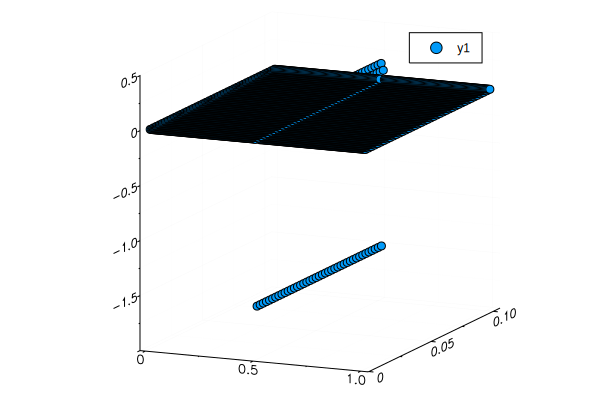

In [215]:
scatter3d(x, y,u)

In [181]:
function InitTest1()

    global problem = prb(0.1,0.3,1.4)
     
    I = 200
    J = 40
    dx = 1.0/I
    dy = 0.1/J
    
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ip =i+(j-1)*(I+1) 
                Tb[ib,1] = ip
                if i==1 
                   Tb[ib,3] = 1
                    Tc[ip,2] =0
                    Tc[ip,3] =0
                end   
                 if  i==I+1 
                    Tb[ib,3] = 1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tc[ip,1] =0
                    Tc[ip,4] =0
                end
            
                if j==1 
                    Tb[ib,2] = 1
                    Tc[ip,3] = 0
                    Tc[ip,4] = 0
                end
                if j==J+1
                    Tb[ib,2] = 1
                    Tc[ip,1] = 0
                    Tc[ip,2] = 0
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = i*dx
            y[ip] = j*dy
            
            u[ip] = 0.0
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = A[1]+A[2]+A[3]+A[4]
            if i<=100
                mz[ic] = 1.0* Az[ic]
                p[ic] = 1.0
                ρ[ic] = 1.0
            else
                mz[ic] = 0.1 * Az[ic]
                p[ic] = 0.1
                ρ[ic] = 0.1
            end
        end
    end
    
    return x,y,u,v,mz,p,ρ,Az
end

InitTest1 (generic function with 1 method)

In [216]:
function Output(x,y,u,v,p,ρ,mz)
    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
    A = zeros(Float64,Ip,6)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\"  ZONE T=\"Zone 1\" 
I=201,J=21,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)

    for i in 1:Ip
        nc = 0
        ρz = 0.0
        pz = 0.0
        for j = 1:4
            ic = Tc[i,j] 
            if ic != 0
                ρz += ρ[ic]
                pz += p[ic]
                nc +=  1
            end
        end
        ρz = ρz/nc
        pz = pz/nc
        A[i,1] = x[i]
        A[i,2] = y[i]
        A[i,3] = u[i]
        A[i,4] = v[i]
        A[i,5] = ρz
        A[i,6] = pz
        
    end
    writedlm(io, A, "  ")
    close(io)
end

Output (generic function with 1 method)

In [122]:
Output(x,y,u,v,p,ρ,mz)

In [35]:
struct prb
    tt::Float64
    sf::Float64
    γ ::Float64
end

In [204]:
function Area3(x1,x2,x3,y1,y2,y3)
    return abs((x1*y2+y1*x3+x2*y3-x1*y3-y1*x2-y2*x3)/2)
end

Area3 (generic function with 1 method)

In [34]:
using BenchmarkTools
@btime sum(i for i in 1:4)

  2.515 ns (0 allocations: 0 bytes)


10

In [96]:
using DelimitedFiles

In [51]:
typeof(A)

Tuple{Int64,Int64,Int64}

In [52]:
A ::Tuple

(3, 2, 2)

In [53]:
A[1] = (3,2,2)

MethodError: MethodError: no method matching setindex!(::Tuple{Int64,Int64,Int64}, ::Tuple{Int64,Int64,Int64}, ::Int64)

BoundsError: BoundsError

In [70]:
? append!

search: append!



```
append!(collection, collection2) -> collection.
```

Add the elements of `collection2` to the end of `collection`.

# Examples

```jldoctest
julia> append!([1],[2,3])
3-element Array{Int64,1}:
 1
 2
 3

julia> append!([1, 2, 3], [4, 5, 6])
6-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6
```

Use [`push!`](@ref) to add individual items to `collection` which are not already themselves in another collection. The result of the preceding example is equivalent to `push!([1, 2, 3], 4, 5, 6)`.

---

```
append!(cb, datavec)
```

Push at most last `capacity` items.


In [63]:
B = [1; 2; 3; 4]

4-element Array{Int64,1}:
 1
 2
 3
 4

In [68]:
? BitArray

search: BitArray



```
BitArray{N} <: AbstractArray{Bool, N}
```

Space-efficient `N`-dimensional boolean array, using just one bit for each boolean value.

`BitArray`s pack up to 64 values into every 8 bytes, resulting in an 8x space efficiency over `Array{Bool, N}` and allowing some operations to work on 64 values at once.

By default, Julia returns `BitArrays` from [broadcasting](@ref Broadcasting) operations that generate boolean elements (including dotted-comparisons like `.==`) as well as from the functions [`trues`](@ref) and [`falses`](@ref).

---

```
BitArray(undef, dims::Integer...)
BitArray{N}(undef, dims::NTuple{N,Int})
```

Construct an undef [`BitArray`](@ref) with the given dimensions. Behaves identically to the [`Array`](@ref) constructor. See [`undef`](@ref).

# Examples

```julia-repl
julia> BitArray(undef, 2, 2)
2×2 BitArray{2}:
 false  false
 false  true

julia> BitArray(undef, (3, 1))
3×1 BitArray{2}:
 false
 true
 false
```

---

```
BitArray(itr)
```

Construct a [`BitArray`](@ref) generated by the given iterable object. The shape is inferred from the `itr` object.

# Examples

```jldoctest
julia> BitArray([1 0; 0 1])
2×2 BitArray{2}:
  true  false
 false   true

julia> BitArray(x+y == 3 for x = 1:2, y = 1:3)
2×3 BitArray{2}:
 false   true  false
  true  false  false

julia> BitArray(x+y == 3 for x = 1:2 for y = 1:3)
6-element BitArray{1}:
 false
  true
 false
  true
 false
 false
```
